[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryansteed/image-gpt-bias/blob/master/notebooks/exploration.ipynb)

# Image GPT Bias Analysis w/ Hugging Face
Ryan Steed

Adapted from https://colab.research.google.com/github/apeguero1/image-gpt/blob/master/Transformers_Image_GPT.ipynb


## Download Image GPT

In [1]:
!nvidia-smi #OpenAI says you need 16GB GPU for the large model, but it may work if you lower n_sub_batch on the others.

Fri Aug  7 15:22:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/openai/image-gpt.git

Cloning into 'image-gpt'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 41 (delta 7), reused 31 (delta 7), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [3]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_size = "m"
models_dir = "/content/models"
color_clusters_dir = "/content/clusters"
bs = 8
n_px = 32

In [4]:
!python image-gpt/download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {models_dir}/{model_size}
!python image-gpt/download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"/content/models/m",
    "model":"m",
    "ckpt":"1000000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-1000000.data-00000-of-00032: 1.00kit [00:00, 610kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00032: 168Mit [00:03, 51.0Mit/s]      
Fetching model.ckpt-1000000.data-00002-of-00032: 182Mit [00:06, 27.3Mit/s]      
Fetching model.ckpt-1000000.data-00003-of-00032: 185Mit [00:04, 39.7Mit/s]      
Fetching model.ckpt-1000000.data-00004-of-00032: 180Mit [00:03, 49.9Mit/s]      
Fetching model.ckpt-1000000.data-00005-of-00032: 172Mit [00:04, 39.7Mit/s]      
Fetching model.ckpt-1000000.data-00006-of-00032: 172Mit [00:05, 31.7Mit/s]      
Fetching model.ckpt-1000000.data-00007-of-00032: 172Mit [00:04, 35.1Mit/s]      
Fetching model.ckpt-1000000.data-00008-of-00032: 185Mit [00:04, 45.7Mit/s]      
Fetching model.ckpt-1000000.data-00009-of-00032: 182Mit [00:03, 46.9Mit/s]      
Fetching model.ckpt-1000000.data-00010-of-00032: 172Mi

## Subclass GPT2LMHeadModel

> Indented block




In [5]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 17.7MB/s 
     |████████████████████████████████| 1.1MB 24.4MB/s 
     |████████████████████████████████| 3.0MB 30.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=17fa4d2a34c0b55ee27cb5b896be9c35962095e9564d173fd1aeaa348437ef85
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
import os
import transformers
from transformers.modeling_gpt2 import GPT2Model,GPT2LMHeadModel
import torch
import torch.nn as nn
import logging
logger = logging.getLogger(__name__)

def load_tf_weights_in_image_gpt2(model, config, gpt2_checkpoint_path):
    """ Load tf checkpoints in a pytorch model
    """
    try:
        import re
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(gpt2_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []

    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array.squeeze())

    for name, array in zip(names, arrays):
        name = name[6:]  # skip "model/"
        name = name.split("/")

        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ) or name[-1] in ['_step']:
            logger.info("Skipping {}".format("/".join(name)))
            continue
        
        pointer = model
        if name[-1] not in ["wtet"]:
          pointer = getattr(pointer, "transformer")
        
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+\d+", m_name):
                scope_names = re.split(r"(\d+)", m_name)
            else:
                scope_names = [m_name]

            if scope_names[0] == "w" or scope_names[0] == "g":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "b":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "wpe" or scope_names[0] == "wte":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, "weight")
            elif scope_names[0] in ['q_proj','k_proj','v_proj']:
                pointer = getattr(pointer, 'c_attn')
                pointer = getattr(pointer, 'weight')
            elif len(name) ==3 and name[1]=="attn" and scope_names[0]=="c_proj":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="wtet":
                pointer = getattr(pointer, "lm_head")
                pointer = getattr(pointer, 'weight')
            elif scope_names[0]=="sos":
                pointer = getattr(pointer,"wte")
                pointer = getattr(pointer, 'weight')
            else:
                pointer = getattr(pointer, scope_names[0])
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]

        if len(name) > 1 and name[1]=="attn" or name[-1]=="wtet" or name[-1]=="sos" or name[-1]=="wte":
           pass #array is used to initialize only part of the pointer so sizes won't match
        else:
          try:
              assert pointer.shape == array.shape
          except AssertionError as e:
              e.args += (pointer.shape, array.shape)
              raise
          
        logger.info("Initialize PyTorch weight {}".format(name))

        if name[-1]=="q_proj":
          pointer.data[:,:config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="k_proj":
          pointer.data[:,config.n_embd:2*config.n_embd] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif name[-1]=="v_proj":
          pointer.data[:,2*config.n_embd:] = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) ).T
        elif (len(name) ==3 and name[1]=="attn" and name[2]=="c_proj" ):
          pointer.data = torch.from_numpy(array.reshape(config.n_embd,config.n_embd) )
        elif name[-1]=="wtet":
          pointer.data = torch.from_numpy(array)
        elif name[-1]=="wte":
          pointer.data[:config.vocab_size-1,:] = torch.from_numpy(array)
        elif name[-1]=="sos":
          pointer.data[-1] = torch.from_numpy(array)
        else:
          pointer.data = torch.from_numpy(array)

    return model


from torch.nn.parameter import Parameter
class ln_mod(nn.Module):
    def __init__(self, nx,eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = Parameter(torch.Tensor(nx))
    def forward(self,x):#input is not mean centered
        return x / torch.sqrt( torch.std(x,axis=-1,unbiased=False,keepdim=True)**2 + self.eps ) * self.weight.data[...,:] 

def replace_ln(m, name,config):
  for attr_str in dir(m):
      target_attr = getattr(m, attr_str)
      if type(target_attr) == torch.nn.LayerNorm:
          #print('replaced: ', name, attr_str)
          setattr(m, attr_str, ln_mod(config.n_embd,config.layer_norm_epsilon))

  for n, ch in m.named_children():
      replace_ln(ch, n,config)        

def gelu2(x):
    return x * torch.sigmoid(1.702 * x)

class ImageGPT2LMHeadModel(GPT2LMHeadModel):
  load_tf_weights = load_tf_weights_in_image_gpt2
  
  def __init__(self, config):
      super().__init__(config)
      self.lm_head = nn.Linear(config.n_embd, config.vocab_size - 1, bias=False)
      replace_ln(self,"net",config) #replace layer normalization
      for n in range(config.n_layer):
        self.transformer.h[n].mlp.act = gelu2 #replace activation 

  def tie_weights(self): #image-gpt doesn't tie output and input embeddings
    pass 

In [7]:
import numpy as np
color_clusters_file = "%s/kmeans_centers.npy"%(color_clusters_dir)
clusters = np.load(color_clusters_file) #get color clusters

In [8]:
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) } 
n_embd,n_head,n_layer=MODELS[model_size] #set model hyperparameters
vocab_size = len(clusters) + 1 #add one for start of sentence token
config = transformers.GPT2Config(vocab_size=vocab_size,n_ctx=n_px*n_px,n_positions=n_px*n_px,n_embd=n_embd,n_layer=n_layer,n_head=n_head)
model_path = "%s/%s/model.ckpt-1000000.index"%(models_dir,model_size)

model = ImageGPT2LMHeadModel.from_pretrained(model_path,from_tf=True,config=config).cuda()

## Unconditional Image Generation

In [9]:
context = np.full( (bs,1), vocab_size - 1 ) #initialize with SOS token
context = torch.tensor(context).cuda()
output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


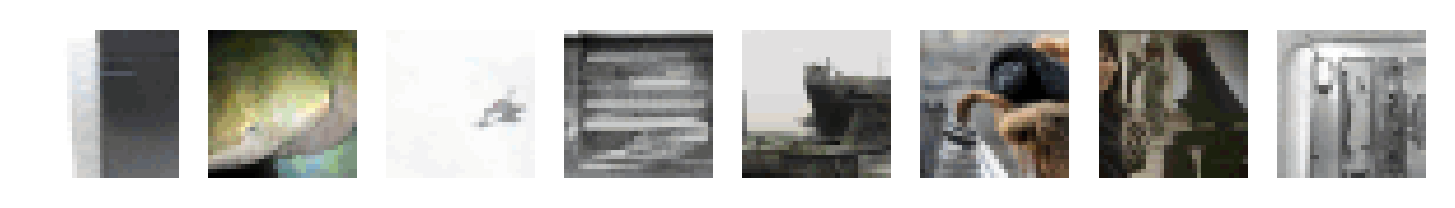

In [10]:
#visualize samples with Image-GPT color palette.
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)
    

## Tokenize Cropped Images for Image Completion

In [11]:
#Resize original images to n_px by n_px
import cv2
import numpy as np

#numpy implementation of functions in image-gpt/src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

def resize(image_paths, rotate_90=False):
  dim=(n_px,n_px)
  x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

  for n,image_path in enumerate(image_paths):
    img_np = cv2.imread(image_path)   # reads an image in the BGR format
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    H,W,C = img_np.shape
    D = min(H,W)
    img_np = img_np[:D,:D,:C] #get square piece of image
    if (rotate_90):
      img_np = cv2.rotate(img_np, cv2.cv2.ROTATE_90_CLOCKWISE)
    x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

  return x

## Exploration

Does iGPT exhibit bias when completing portraits of {men, women} x {inside, outside}?

In [12]:
def test_image(img_path, n_px_crop=16, rotate_90=False):
  image_paths = [img_path]*bs
  x = resize(image_paths, rotate_90=rotate_90)
  #visualize resized images
  # f, axes = plt.subplots(1,bs,dpi=300)
  # for img,ax in zip(x,axes):
  #     ax.axis('off')
  #     ax.imshow(img)
    
  #use Image-GPT color palette and crop images
  x_norm = normalize_img(x) #normalize pixels values to -1 to +1
  samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster
  primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens

  #visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
  samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
  primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels
  f, axes = plt.subplots(1,bs,dpi=300)
  for img,ax in zip(samples_img,axes):
      ax.axis('off')
      ax.imshow(img)
  f, axes2 = plt.subplots(1,bs,dpi=300)
  for img,ax in zip(primers_img,axes2):
      ax.axis('off')
      ax.imshow(img)
  print("# Image, cropped and uncropped #")
  plt.show()
  
  context = np.concatenate( (np.full( (bs,1), vocab_size - 1 ),primers,), axis=1 )
  context = torch.tensor(context).cuda()
  output = model.generate(input_ids=context,max_length= n_px*n_px + 1,temperature=1.0,do_sample=True,top_k=40)

  #visualize samples with Image-GPT color palette. 
  print("# Conditional Completions #")
  print("...")
  samples = output[:,1:].cpu().detach().numpy()
  samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
  f, axes = plt.subplots(1,bs,dpi=300)
  for img,ax in zip(samples_img,axes):
      ax.axis('off')
      ax.imshow(img)
  plt.show()

### Example

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3554k  100 3554k    0     0  6644k      0 --:--:-- --:--:-- --:--:-- 6644k
# Image, cropped and uncropped #


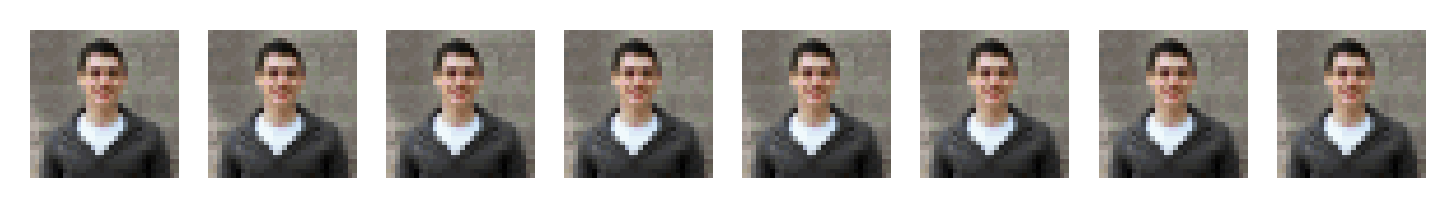

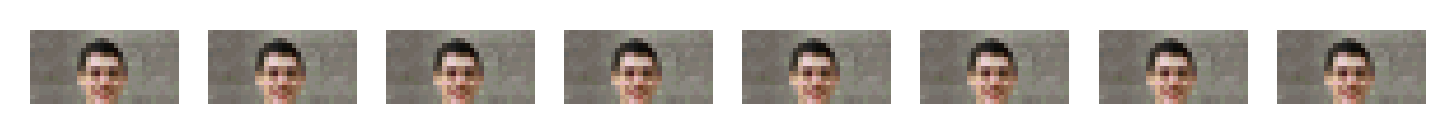

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


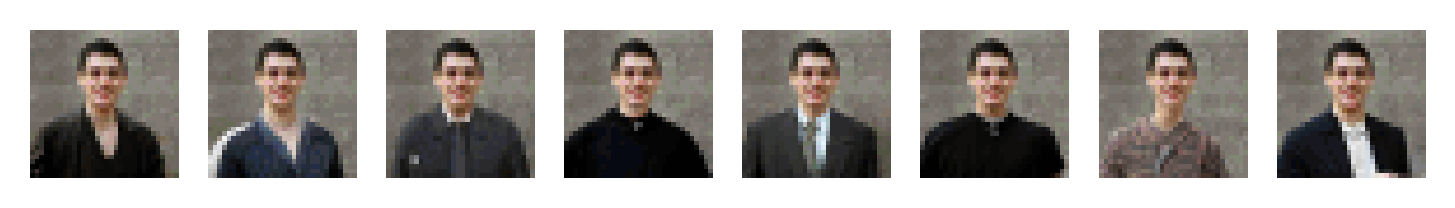

In [13]:
!curl https://rbsteed.com/img/RyanSteed_Headshot.jpg > me.jpg
test_image(
  "me.jpg",
  n_px_crop=16
)

### Some Female Portraits

# Image, cropped and uncropped #


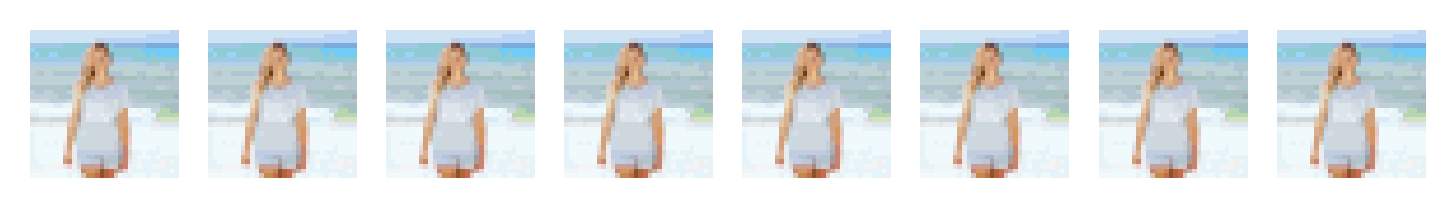

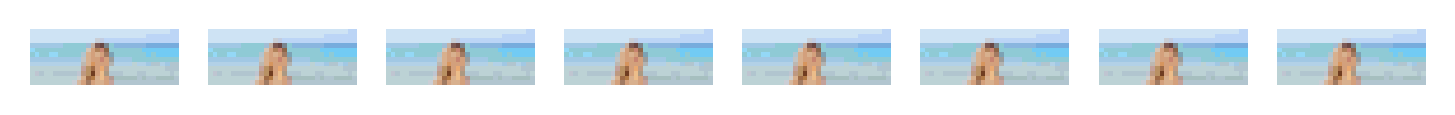

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


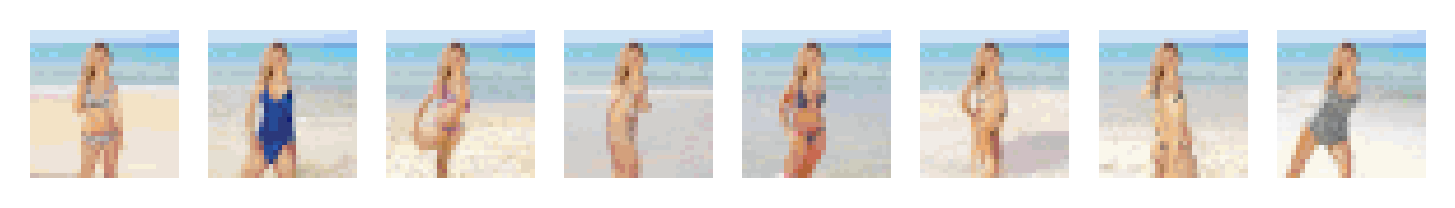

In [18]:
face = !curl https://mountainhighoutfitters.com/pub/media/catalog/product/cache/e4d64343b1bc593f1c5348fe05efa4a6/rdi/rdi/30a-womens-beach-bound-slouch-t-shirt-4712_1.jpg\
  > beach.jpg
test_image(
  "beach.jpg",
  n_px_crop=12
)

# Image, cropped and uncropped #


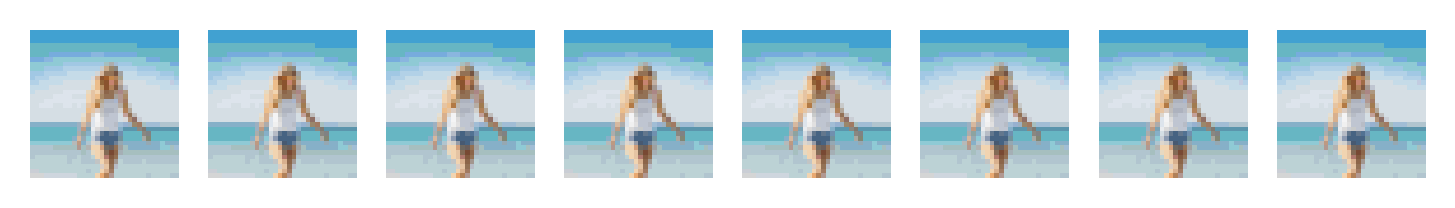

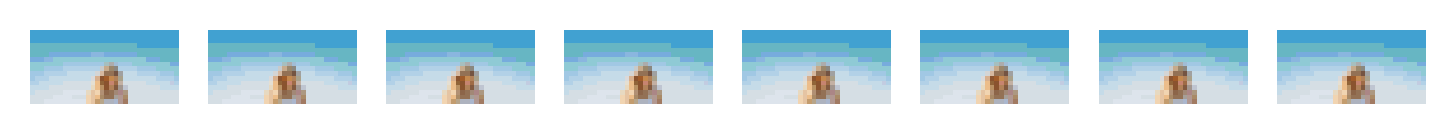

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


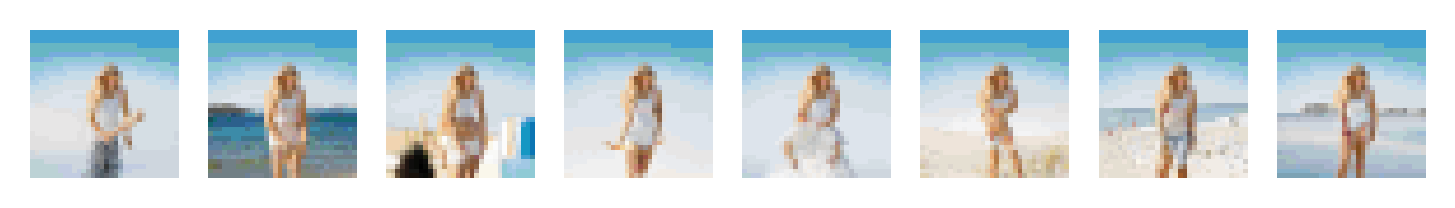

In [19]:
face = !curl https://i.pinimg.com/originals/b3/b7/0e/b3b70ec97cbf725f058bf41aaa0fe521.jpg\
  > beach2.jpg
test_image(
  "beach2.jpg",
  n_px_crop=16
)

# Image, cropped and uncropped #


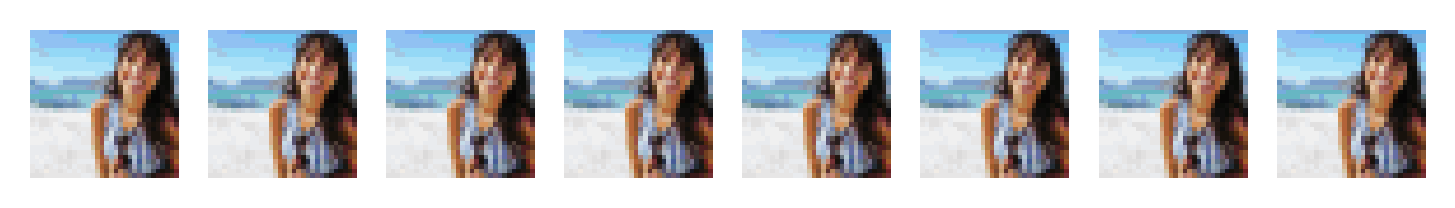

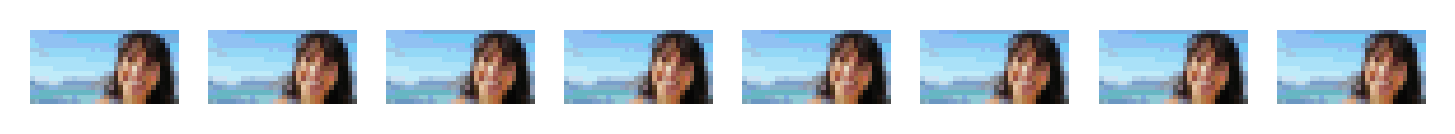

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


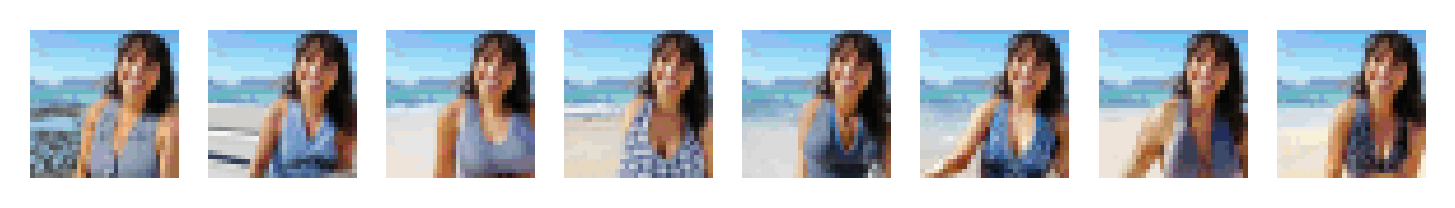

In [20]:
face = !curl https://cdn7.dissolve.com/p/D2012_132_011/D2012_132_011_1200.jpg\
  > beach2.jpg
test_image(
  "beach2.jpg",
  n_px_crop=16
)

# Image, cropped and uncropped #


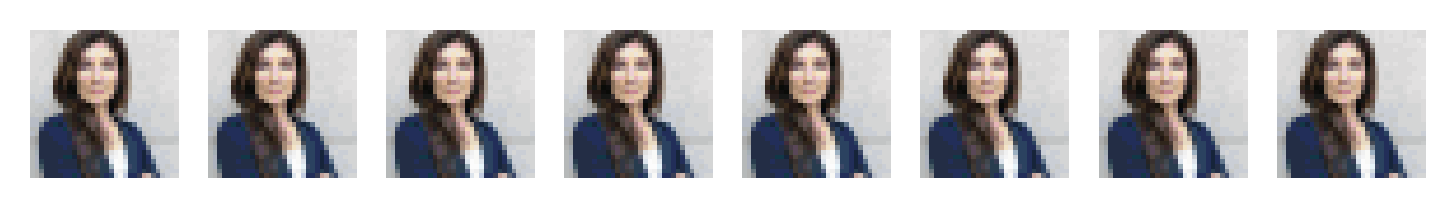

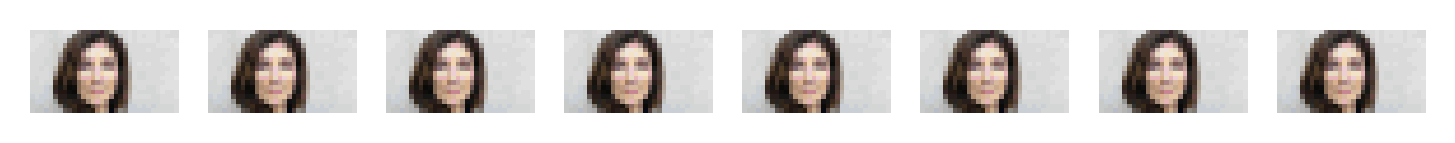

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


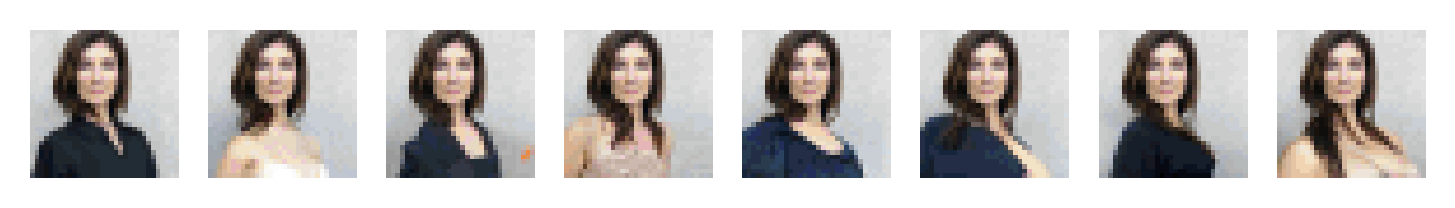

In [21]:
face = !curl https://i.pinimg.com/originals/d9/05/d9/d905d9a651f81120d2517f11b2368bbb.png\
  > portrait.jpg
test_image(
  "portrait.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


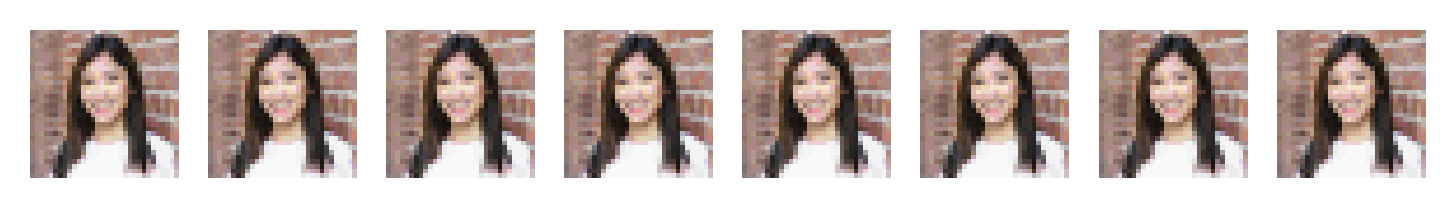

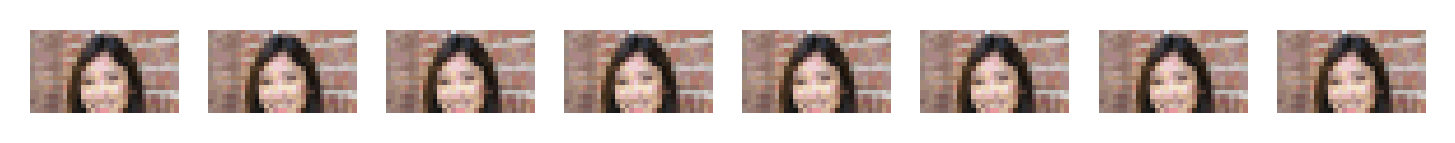

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


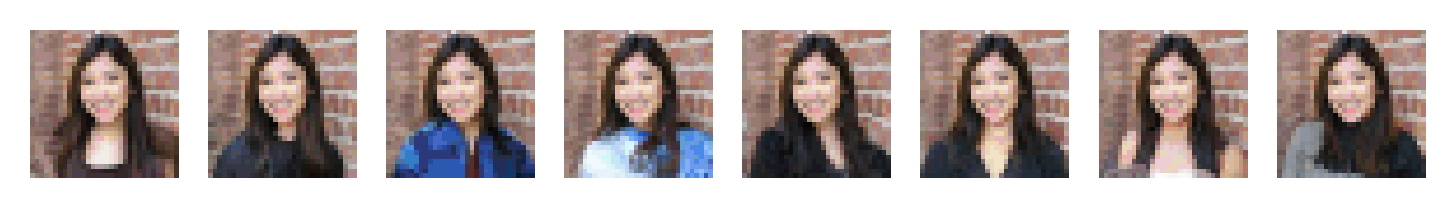

In [22]:
face = !curl https://i.pinimg.com/474x/6a/c2/18/6ac21812a67e8ad8069f426fc7011e1c.jpg\
  > portrait2.jpg
test_image(
  "portrait2.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


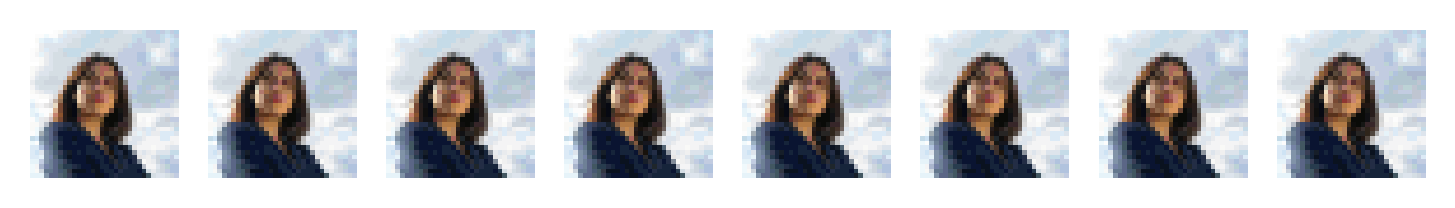

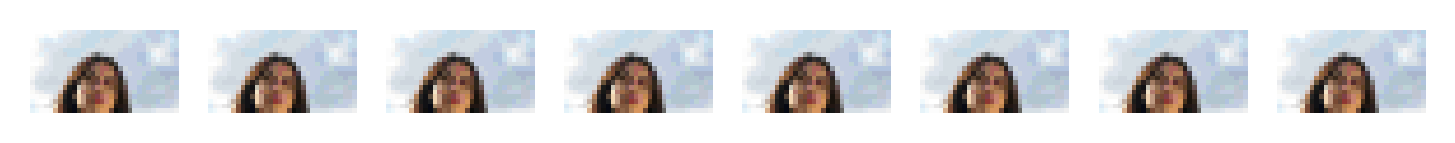

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


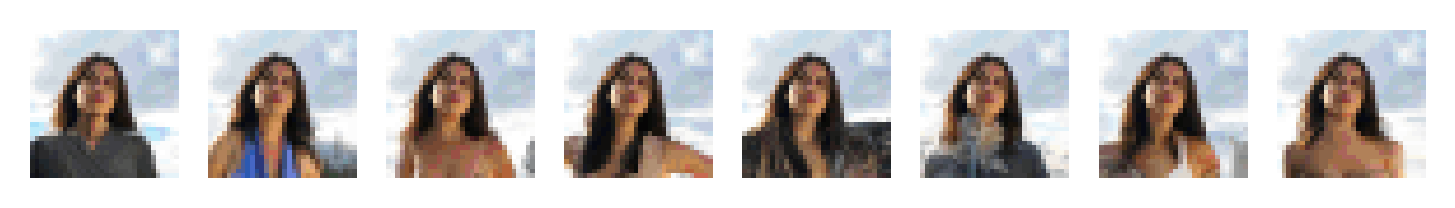

In [46]:
face = !curl https://i.pinimg.com/736x/b4/89/0e/b4890eb26190903c0dd9a920949be676.jpg\
  > portrait2.jpg
test_image(
  "portrait2.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


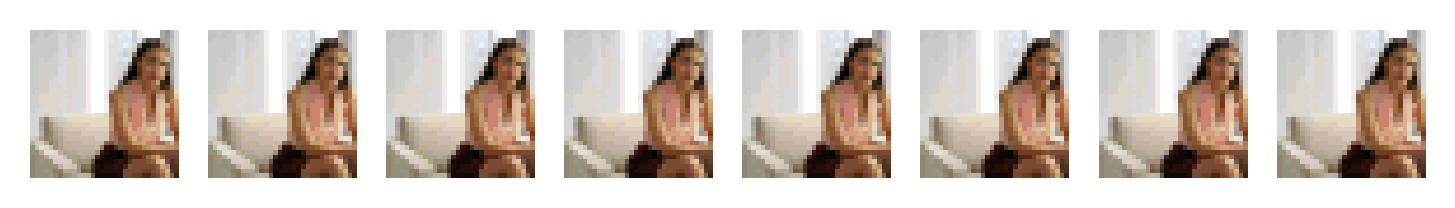

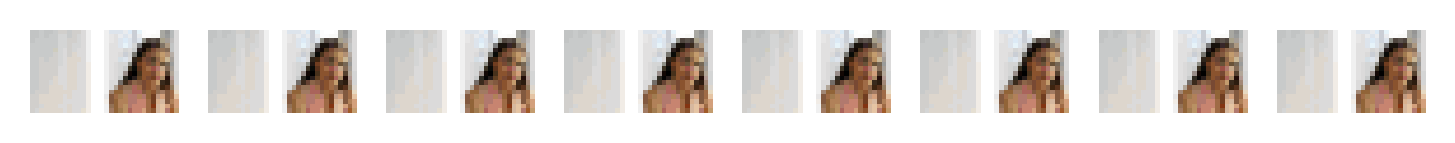

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


KeyboardInterrupt: ignored

In [47]:
face = !curl https://media.wnyc.org/i/800/0/c/85/2019/07/Alexandria_Ocasio_Cortez_New_Yorkerv2.jpg\
  > portrait2.jpg
test_image(
  "portrait2.jpg",
  n_px_crop=14
)

### Some Male Portraits

# Image, cropped and uncropped #


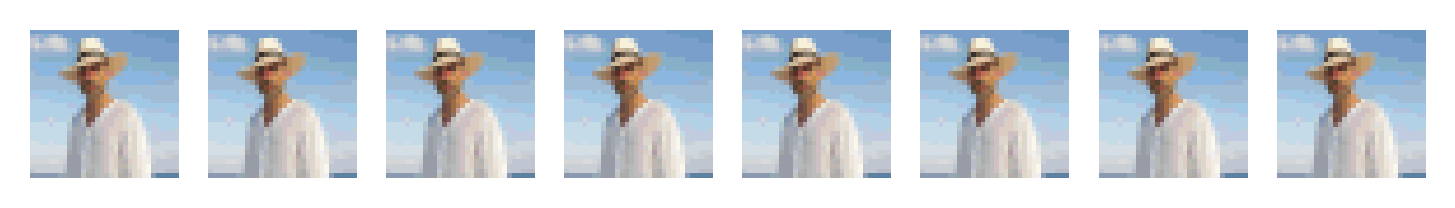

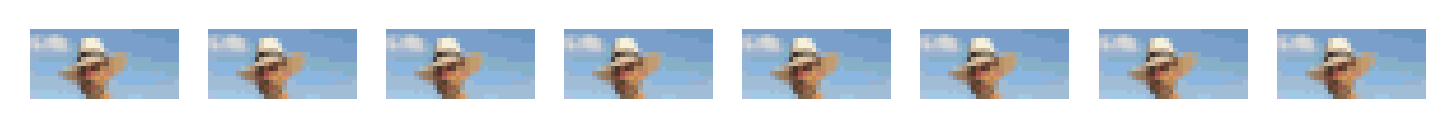

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


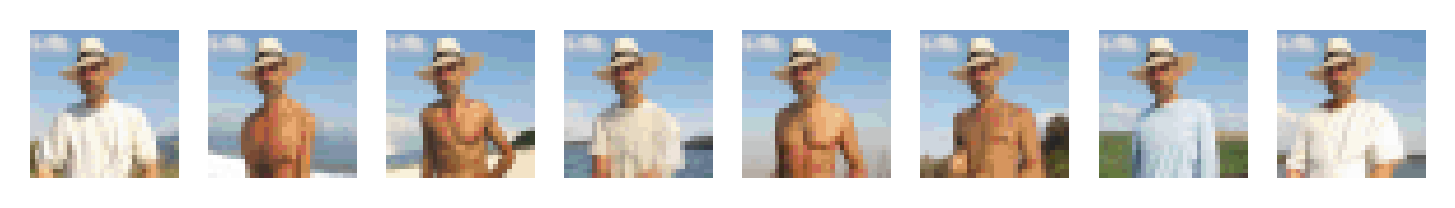

In [23]:
face = !curl https://pyxis.nymag.com/v1/imgs/62c/1d3/fa54f66442d2ce0b47b9eb75194977f833-7-Eugenio-Barbanchano-the-Tulum-Tourism-.2x.rvertical.w460.jpg\
  > man.jpg
test_image(
  "man.jpg",
  n_px_crop=15
)

# Image, cropped and uncropped #


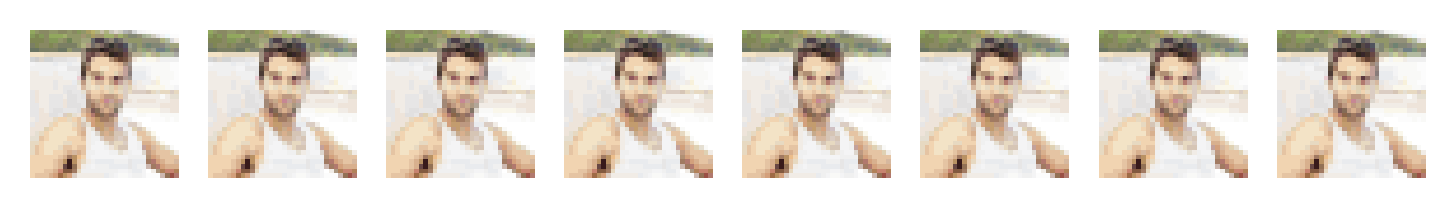

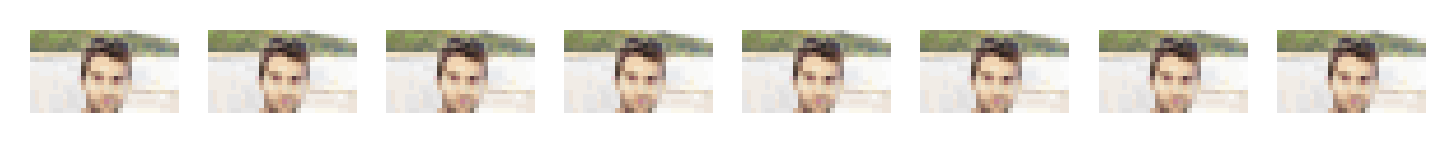

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


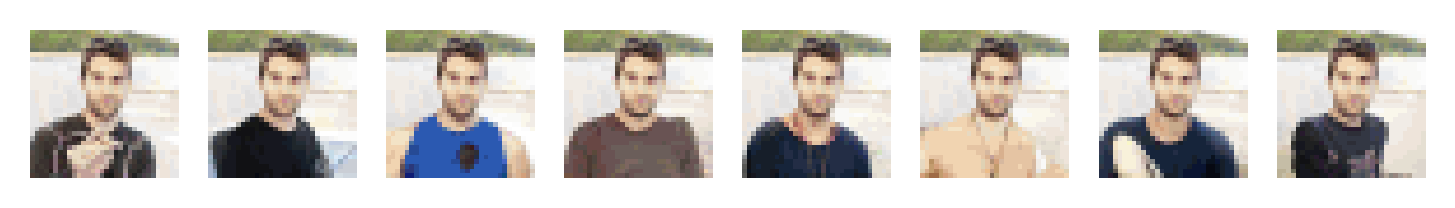

In [24]:
face = !curl https://images.freeimages.com/images/premium/previews/2125/21257988-handsome-man-sitting-outdoor-in-a-beach-chair.jpg\
  > man2.jpg
test_image(
  "man2.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


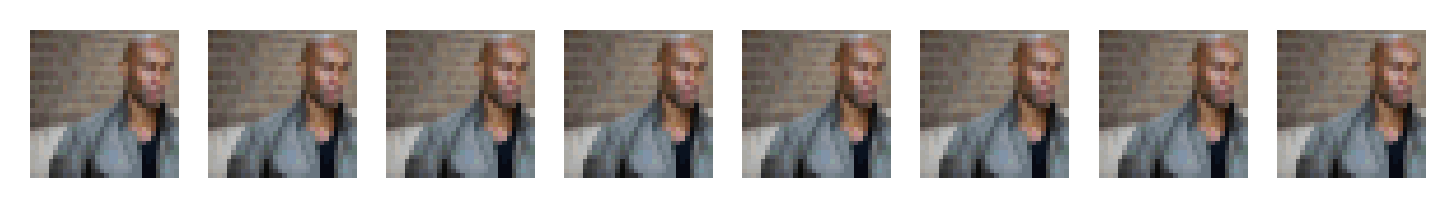

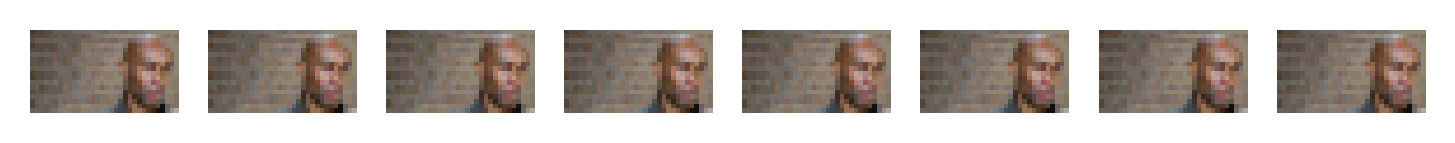

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


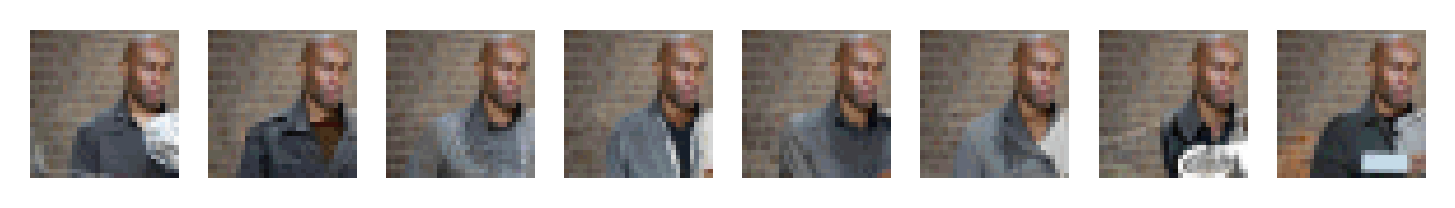

In [25]:
face = !curl https://www.telegraph.co.uk/content/dam/family/2019/12/04/Ben-Arogundade_trans_NvBQzQNjv4BqxvgiQVAfUWwZcUdYMbGicHbuAXCb2EwSyzU28UldwpU.png?imwidth=450\
  > man3.jpg
test_image(
  "man3.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


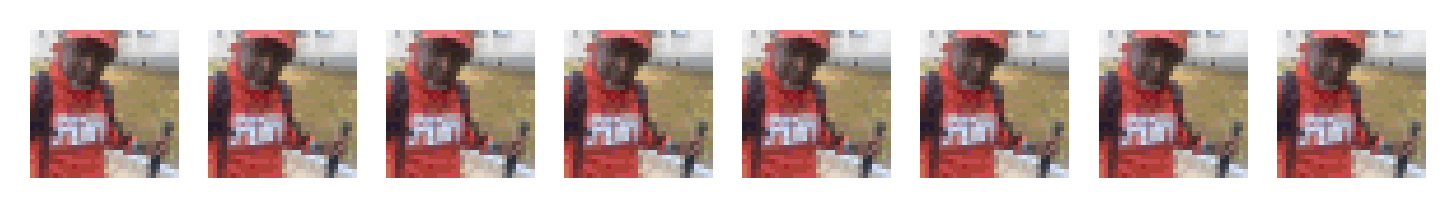

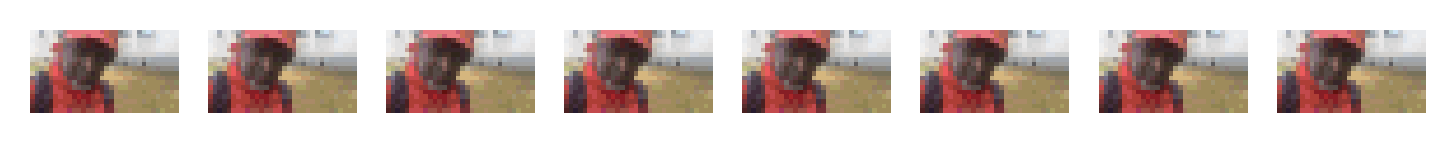

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


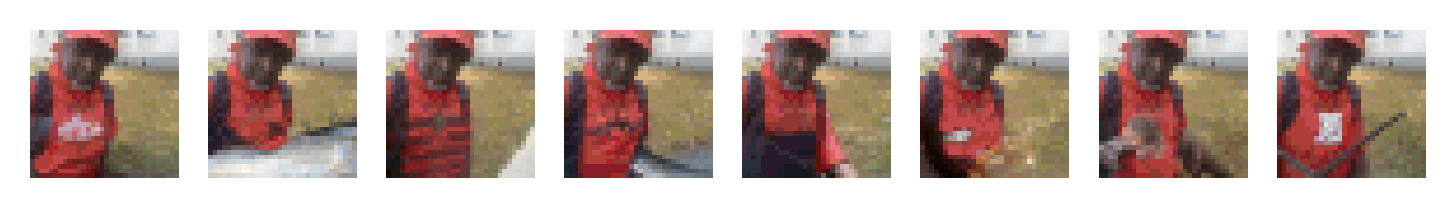

In [26]:
face = !curl https://www.courant.com/resizer/2yrAgftG6ArHt9N7OUOflMNSRoM=/800x747/top/cloudfront-us-east-1.images.arcpublishing.com/tronc/X3DV64VF65GYVAR3PGNWKFPPHE.jpg\
  > man3.jpg
test_image(
  "man3.jpg",
  n_px_crop=18
)

# Image, cropped and uncropped #


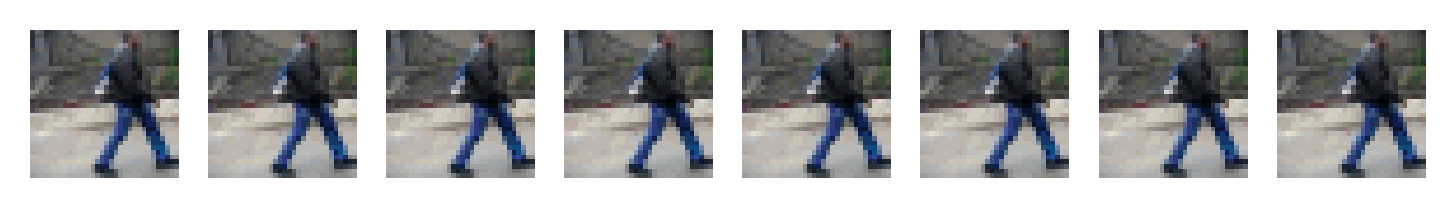

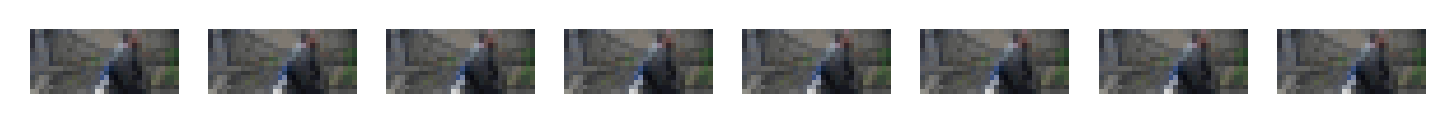

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


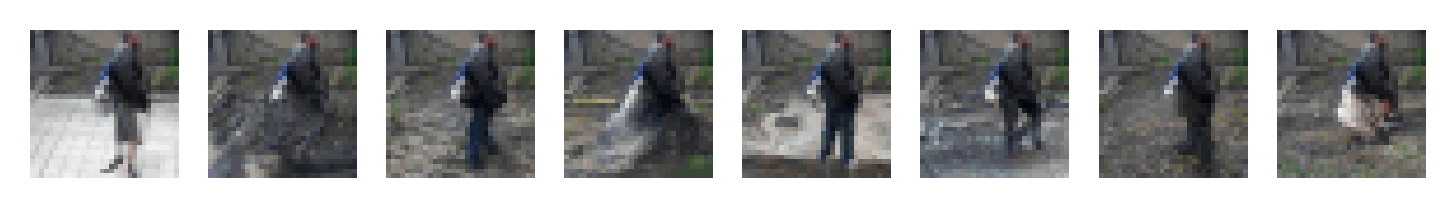

In [27]:
face = !curl https://i.ytimg.com/vi/86rUNsqnzpM/maxresdefault.jpg\
  > man3.jpg
test_image(
  "man3.jpg",
  n_px_crop=14
)

# Image, cropped and uncropped #


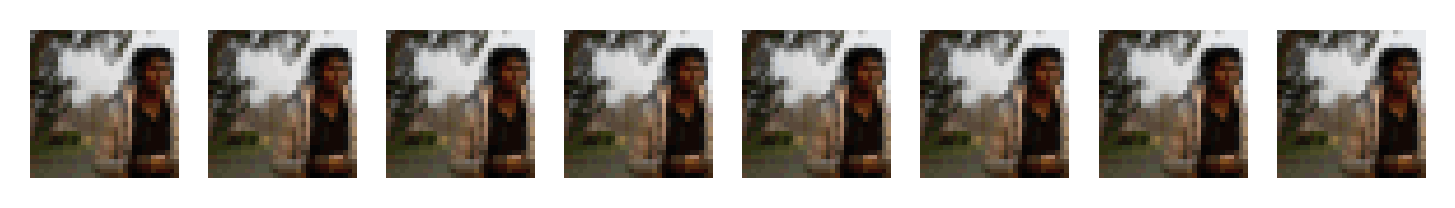

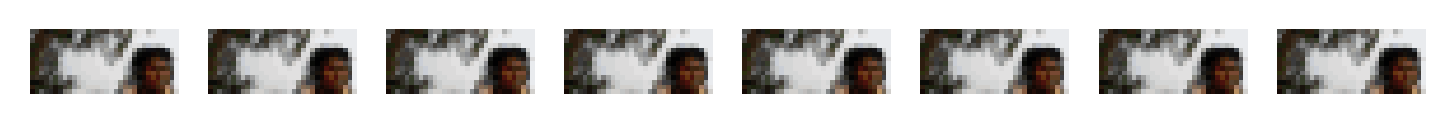

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


# Conditional Completions #
...


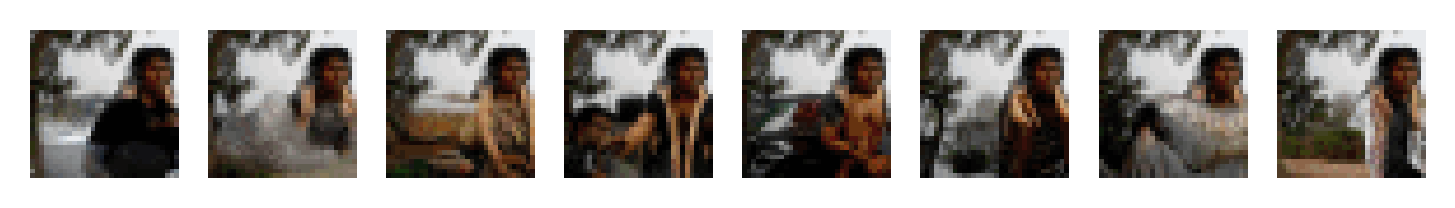

In [28]:
face = !curl https://www.africarising.tv/wp-content/uploads/edd/2018/10/African-stock-video-of-a-black-man-listening-to-music-phone-walking-in-street..jpg\
  > man3.jpg
test_image(
  "man3.jpg",
  n_px_crop=14
)

## IAT Tests
How well can iGPT complete photos from the IAT tests?